# PROJECT WORK
#### 1. Problem Description 

The dataset named Star is obtained from the website http://vincentarelbundock.github.io/Rdatasets/datasets.html. The dataset is a collection of 5748 observations of individual performance in math and reading tests accross 79 different schools. The variables are class sizes, years of teaching experience, gender, qualified for free lunch and race. Below are 5 example instances of the original dataset:

![Data](./Fig/OriginalData.png)


For the scope of this project work, we focus on choosing only one variable and regress math scores based on that variable. The variable chosen here is years of teaching experience. Comparing the original distribution of math scores vs. log-scale of math scores, log-scale math scores seems to follow normal distribution better. Therefore, we choose to build our models with log-scale math scores. 

Data distribution:
![Math](./Fig/Math.png)


#### 2. Model description

In the sections following, we will go through 4 different models:

- Pooled model: all school belongs to the same distribution, log math scores is regressed based on years of teaching experience.  Parameters are beta1, beta2 and sigma that are common for all schools.  
                                        y ~ N(beta1 + beta2*x, sigma) 
- Separate model: each school has its own separate model. The parameters are alpha (unique for each school), beta and sigma (common for all schools)
                                        mu = alpha_school + beta*x
                                        y ~ N(mu, sigma)
- Varying slop and intercept model: each school has its own separate model with both alpha and beta unique for each school, sigma is common for all schools. Alpha and beta follows normal distribution with priors:
                                        mu_alpha ~ N(0,1)
                                        mu_beta ~ N(0,1)
                                        alpha ~ N(mu_alpha, sigma_alpha)
                                        alpha ~ N(mu_alpha, sigma_alpha)
                                        mu = alpha_school + beta_school*x
                                        y ~ N(mu, sigma)
- Hierarchical model: Similar to the varying slope and intercept model but we only use prior for alpha. 
                                        mu_alpha ~ N(0,1)
                                        alpha ~ N(mu_alpha, sigma_alpha)
                                        beta ~ N(0,1)
                                        mu = 
                                        y ~ N(mu, sigma)

For evaluation purpose, we split up training-test data with the corresponding percentage 75-25 to evaluate the accuracy of each models. 

The codes are passed to PyStan and simulated with 2 chains in 1000 iterations. 

#### 2.1. Pooled model 

Stan code:

`data {
    int<lower=0>  N; //Number of train data
    int<lower=0> M; //Number of test data
    vector[N] x; // Variable - teaching experience
    vector[M] x_test; // Test variable 
    vector[N] y; // Labels - log math score
}
parameters {
    vector[2] beta;
    real<lower=0> sigma; //sigma is constrained to be positive 
}
model {
    y ~ normal(beta[1] + beta[2]*x, sigma); 
}
generated quantities{
    vector[N] log_lik;
    vector[M] y_pred_test;
    for (i in 1:M)
     y_pred_test[i] = normal_rng(beta[1] + beta[2]*x_test[i], sigma);
    for (i in 1:N)
     log_lik[i] = normal_lpdf(y[i]| beta[1] + beta[2]*x[i], sigma);
}`

#### 2.2. Separate model 

Stan code

`data{
    int<lower=0> N;
    int<lower=1, upper=79> school[N]; #school indicator
    vector[N] x;
    vector[N] y;
}
parameters {
    vector[79] alpha;
    real beta; 
    real<lower=0> sigma;
}
transformed parameters {
    vector[N] mu;  
    for (i in 1:N)
        mu[i] <- beta* x[i] + alpha[school[i]];
}
model {
    y ~ normal(mu, sigma);
}
generated quantities{
    vector[N] log_lik;
    for (i in 1:N)
     log_lik[i] = normal_lpdf(y[i]| mu[i], sigma);
}`

#### 2.3. Varying intercept and slope model 
Stan code:

    `data {
      int<lower=0> N;
      int<lower=0> J;
      vector[N] y;
      vector[N] x;
      int school[N];
    }
    parameters {
      real<lower=0> sigma;
      real<lower=0> sigma_a;
      real<lower=0> sigma_b;
      vector[J] alpha;
      vector[J] beta;
      real mu_a;
      real mu_b;
    }
    transformed parameters {
        vector[N] mu;  
        for (i in 1:N)
            mu[i] <- alpha[school[i]] + beta[school[i]]*x[i];
    }
    model {
      mu_a ~ normal(0, 1);
      mu_b ~ normal(0, 1);

      alpha ~ normal(mu_a, sigma_a);
      beta ~ normal(mu_b, sigma_b);
      y ~ normal(mu, sigma);
    }

    generated quantities{
        vector[N] log_lik;
        for (i in 1:N)
         log_lik[i] = normal_lpdf(y[i]| mu[i], sigma);
    }`

#### 2.4. Hierarchical model 
Stan code:

#### 3. Convergence and Result
#### 3.1. Pooled model 

R-hat for all variables is approximately 1.0, so we can conclude that the model has converged. Checking effective sample size and divergence returns value True, meaning that there is no problem with the model. The graph below demonstrates the fitted line. 
![Pooledmodel](./Fig/Pooledmodel.png)


#### 3.2. Separate model  
R-hat for all variables is approximately 1.0, so we can conclude that the model has converged. Checking effective sample size and divergence returns value True, meaning that there is no problem with the model.
Alpha (intercept) calculated for different schools:
![Sepmodel_alpha](./Fig/Intercept_separate.png)

#### 3.3. Varying intercept and slope model
R-hat for all variables is approximately 1.0, so we can conclude that the model has converged. Checking effective sample size and divergence returns value True, meaning that there is no problem with the model.
Alpha (intercept) calculated for different schools:
![varymodel_alpha](./Fig/Intercept_varymodel.png)


Beta (slope) calculated for different schools:
![varymodel_beta](./Fig/Slope_Varymodel.png)


#### 3.4. Hierarchical model  



#### 4. Model evaluation with Psis-loo 

Two methods for model evaluation has been used in this project: psis-loo and MAE.

Psisloo results for each model:

| Measurements | Pooled model | Separate model | Varying intercept and slope | Hierarchical model |
| --- | --- | --- | --- | --- |
| psis-loo | 1960.56 | 2176 | 5908 | --- |
| p_eff | 3 | 80 | -3669 | --- |
| k > 0.5 | None | Some | Some | --- |

Scatter plot of ks values for different models:

- Pooled model: all k values is below 0.5. We can conclude that the parameter estimations of the model is reliable

![k_values_pooled](./Fig/k_pooled.png)

- Separate model: some k values is higher than 0.5. The estimates might be biased. 

![k_values_separate](./Fig/k_separate.png)

- Vary slope and intercept model: some k values is higher than 0.5. The estimates might be biased. 

![k_values_vary](./Fig/k_varymodel.png)

- Hierarchical model:

#### 5. Posterior predictive checking  
MAE and MSE results for each model:

| Measurements | Pooled model | Separate model | Varying intercept and slope | Hierarchical model |
| --- | --- | --- | --- | --- |
| MAE | 0.077 | 0.069 | --- | --- |
| MSE| 0.009 | 0.079 | --- | --- |

Posterior distribution:

- Pooled model
- Separate model
- Vary slope and intercept model
- Hierarchical model 

Model comparison: Model .... is most suitable for the dataset because ....

#### 6. Conclusion and potential improvements
In conclusion, it seems that model ... performs the best. 

<What can be concluded from the result? Does school level affect performance? Does teaching experience affect performance? What to do to maximize math score result?>

Within the scope of this project, we only explore one variable effect on math score results. Further analysis can be done with additional variables to improve prediction accuracy.  

#### 7. References

Codes adapted from Fonnesbeck, C. A Primer on Bayesian Multilevel Modeling using PyStan. URL: http://mc-stan.org/users/documentation/case-studies/radon.html?fbclid=IwAR3h_03XtQnyJQ18EOdREkPX-4biDX7c5AN5e9DPQzQLZ6hB2JRFh1gHemQ

Dataset collected from Rdatasets. URL: http://vincentarelbundock.github.io/Rdatasets/datasets.html

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('notebook')
import stanity

In [2]:
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

In [3]:
np.random.seed(10)
import warnings
warnings.filterwarnings('ignore')

In [4]:
star = pd.read_csv('Star.csv', index_col=0, header = 0)

In [5]:
star.head()


,tmathssk,treadssk,classk,totexpk,sex,freelunk,race,schidkn
2,473,447,small.class,7,girl,no,white,63
3,536,450,small.class,21,girl,no,black,20
5,463,439,regular.with.aide,0,boy,yes,black,19
11,559,448,regular,16,boy,no,white,69
12,489,447,small.class,5,boy,yes,white,79


In [6]:
len(np.unique(star.schidkn))

79

In [7]:
schools = star.schidkn.unique()

In [8]:
np.sort(schools)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80])

In [9]:
star.loc[star.schidkn>=78,'schidkn'] -= 1

In [10]:
schools = star.schidkn.unique()

In [11]:
df = pd.DataFrame()

In [12]:
for col in ['tmathssk', 'treadssk', 'totexpk', 'schidkn' ]:
    data = star.loc[:,col]
    df[col] = data
data = star.loc[:,['classk', 'sex', 'freelunk','race']]
df = df.merge(pd.get_dummies(data), left_index=True, right_index=True)

In [13]:
print(df.columns[[4, 6, 8]])
print(df.head())

Index(['classk_regular', 'classk_small.class', 'sex_girl'], dtype='object')
    tmathssk  treadssk  totexpk  schidkn  classk_regular  \
2        473       447        7       63               0   
3        536       450       21       20               0   
5        463       439        0       19               0   
11       559       448       16       69               1   
12       489       447        5       78               0   

    classk_regular.with.aide  classk_small.class  sex_boy  sex_girl  \
2                          0                   1        0         1   
3                          0                   1        0         1   
5                          1                   0        1         0   
11                         0                   0        1         0   
12                         0                   1        1         0   

    freelunk_no  freelunk_yes  race_black  race_other  race_white  
2             1             0           0           0           1  


In [14]:
df.drop(df.columns[[5, 7, 9, 12]], axis=1, inplace=True)

In [15]:
df.columns = ['math', 'reading', 'year_teaching', 'school','reg_class', 'sml_class', 'is_girl', 'free_lunch', 'black','white']

In [16]:
df.head()

,math,reading,year_teaching,school,reg_class,sml_class,is_girl,free_lunch,black,white
2,473,447,7,63,0,1,1,0,0,1
3,536,450,21,20,0,1,1,0,1,0
5,463,439,0,19,0,0,0,1,1,0
11,559,448,16,69,1,0,0,0,0,1
12,489,447,5,78,0,1,0,1,0,1


In [17]:
df.corr()['math'].sort_values()

free_lunch      -0.243111
black           -0.174493
reg_class       -0.036504
school           0.045439
sml_class        0.080078
is_girl          0.081041
year_teaching    0.096687
white            0.174968
reading          0.713549
math             1.000000
Name: math, dtype: float64

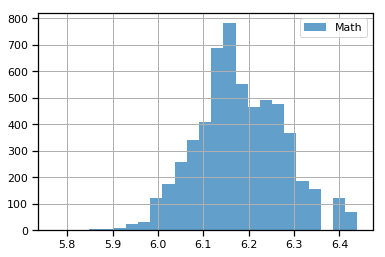

In [18]:
df.math.apply(lambda x:np.log(x)).hist(bins=25, alpha = 0.7, label = "Math")
plt.legend()
plt.show()


### Train/Test Split

In [19]:
X = df.drop('math', axis=1)
Y = np.log(df.math)

In [20]:
indices = range(df.shape[0])
i_schools = []
len_ischools = []

In [21]:
for s in schools:
    i_school = np.where(df.school == s)[0]
    len_ischools.append(len(i_school))
    i_schools.append(i_school)

In [22]:
min_len = min(len_ischools)
train_size = round(min_len*0.8)

In [23]:
train_idx = []
test_idx = []

In [24]:
for s in i_schools:
    np.random.shuffle(s)
    train_idx = np.concatenate((train_idx, s[:train_size]), axis=None)
    test_idx = np.concatenate((test_idx, s[train_size:]), axis=None)

In [25]:
len(train_idx)

2133

In [26]:
len(test_idx)

3615

In [27]:
X_train = X.iloc[train_idx,:]
X_test = X.iloc[test_idx,:].reset_index()
Y_train = Y.iloc[train_idx]
Y_test = Y.iloc[test_idx]

## Pooled model 

In [28]:
pooled_code = """
data {
    int<lower=0>  N;
    int<lower=0> M;
    vector[N] x;
    vector[M] x_test;
    vector[N] y;
}
parameters {
    vector[2] beta;
    real<lower=0> sigma;
}
model {
    y ~ normal(beta[1] + beta[2]*x, sigma);
}
generated quantities{
    vector[N] log_lik;
    vector[M] y_pred_test;
    for (i in 1:M)
     y_pred_test[i] = normal_rng(beta[1] + beta[2]*x_test[i], sigma);
    for (i in 1:N)
     log_lik[i] = normal_lpdf(y[i]| beta[1] + beta[2]*x[i], sigma);
}

"""

In [29]:
import pystan

pool_data = {
    'N': Y_train.shape[0], 
    'M': Y_test.shape[0],
    'x': X_train.loc[:,'year_teaching'],
    'x_test': X_test.loc[:,'year_teaching'],
    'y': Y_train,
}

In [30]:
pooled_fit = pystan.stan(model_code=pooled_code, data = pool_data, iter = 1000, chains = 2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_174aac4ec68a4e0adc2676445f7b9556 NOW.


In [31]:
print("Rhat check : ",pystan.diagnostics.check_rhat(pooled_fit))
print("N_eff check : ",pystan.diagnostics.check_n_eff(pooled_fit))
print("Divergence check: ", pystan.diagnostics.check_div(pooled_fit))

Rhat check :  True
N_eff check :  True
Divergence check:  True


psisloo:  2006.5623330308817
p_eff:  3.12860591199842


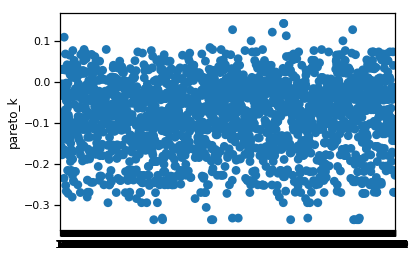

In [32]:
pooled_sample = pooled_fit.extract(permuted=True)

loglik = (pooled_sample["log_lik"])
psisloo = stanity.psisloo(loglik)
print("psisloo: ",psisloo.elpd)
psisloo.plot()
lppd_pooled = 0 
for i in range (Y_train.shape[0]):
    lppd_pooled = lppd_pooled + np.log(np.mean(np.exp(loglik[:,i])))

peff_pooled = np.sum(lppd_pooled) - psisloo.elpd
print("p_eff: ", peff_pooled)


In [33]:
psisloo.print_summary()

greater than 0.5    0.0
greater than 1      0.0
dtype: float64

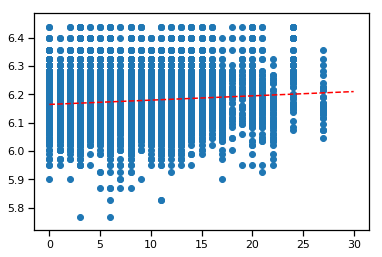

In [34]:
b0, m0 = pooled_sample['beta'].T.mean(1)
plt.scatter(df.year_teaching, np.log(df.math))
xvals = np.linspace(0,30)
plt.plot(xvals, m0*xvals+b0, 'r--')
plt.show()


0.078

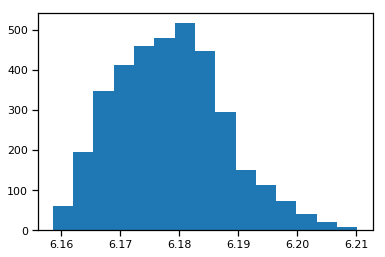

In [35]:
#Comparing y_pred with y_test
y_pred = np.mean(pooled_sample["y_pred_test"], axis=0)
plt.hist(y_pred, bins = 15)
round(MAE(Y_test, y_pred),3)

In [36]:
round(MSE(Y_test, y_pred),3)

0.01

##  Separate model

In [37]:
separate_code = """
data{
    int<lower=0> N;
    int<lower=1, upper=79> school[N]; #school indicator
    vector[N] x;
    vector[N] y;
}
parameters {
    vector[79] alpha;
    real beta; #only 1 beta, not a vector
    real<lower=0> sigma;
}
transformed parameters {
    vector[N] mu;  
    for (i in 1:N)
        mu[i] <- beta* x[i] + alpha[school[i]];
}
model {
    y ~ normal(mu, sigma);
}
generated quantities{
    vector[N] log_lik;
    for (i in 1:N)
     log_lik[i] = normal_lpdf(y[i]| mu[i], sigma);
}
"""

In [38]:
separate_data = {'N': X_train.shape[0],
                 'school': X_train.school,
                 'x': X_train.loc[:,'year_teaching'],
                 'y': Y_train }

In [39]:
separate_fit = pystan.stan(model_code = separate_code, data = separate_data, iter = 1000, chains = 2)
separate_sample = separate_fit.extract(permuted=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3f346b560546d258f094491925426d10 NOW.


In [40]:
print("Rhat check : ",pystan.diagnostics.check_rhat(separate_fit))
print("N_eff check : ",pystan.diagnostics.check_n_eff(separate_fit))
print("Divergence check: ", pystan.diagnostics.check_div(separate_fit))

Rhat check :  True
N_eff check :  True
Divergence check:  True


In [41]:
alpha = np.mean(separate_fit['alpha'], axis=0)
beta = np.mean(separate_fit['beta'])

psisloo:  2210.896499629648
p_eff:  78.64991455064046


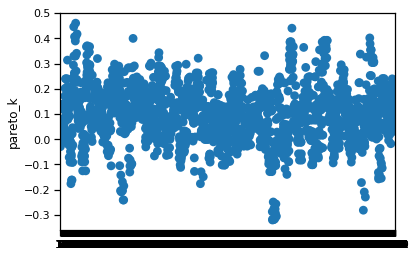

In [42]:
loglik = (separate_sample["log_lik"])
psisloo = stanity.psisloo(loglik)
print("psisloo: ",psisloo.elpd)
psisloo.plot()
lppd_pooled = 0 
for i in range (Y_train.shape[0]):
    lppd_pooled = lppd_pooled + np.log(np.mean(np.exp(loglik[:,i])))

peff_pooled = np.sum(lppd_pooled) - psisloo.elpd
print("p_eff: ", peff_pooled)

In [43]:
psisloo.print_summary()

greater than 0.5    0.0
greater than 1      0.0
dtype: float64

(array([ 60., 195., 347., 411., 459., 479., 516., 447., 295., 151., 112.,
         74.,  40.,  20.,   9.]),
 array([6.15861051, 6.16204683, 6.16548315, 6.16891948, 6.1723558 ,
        6.17579213, 6.17922845, 6.18266478, 6.1861011 , 6.18953742,
        6.19297375, 6.19641007, 6.1998464 , 6.20328272, 6.20671905,
        6.21015537]),
 <a list of 15 Patch objects>)

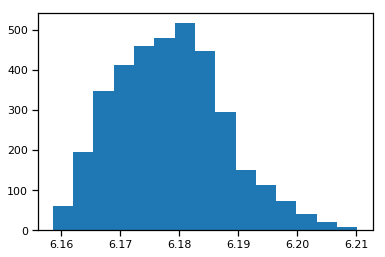

In [44]:
Y_pred = []
for i in range(X_test.shape[0]):
    school = X_test.loc[i, 'school']
    Y_pred.append(alpha[school-1] + beta*X_test.loc[i, 'year_teaching'])

plt.hist(y_pred, bins = 15)

In [45]:
MAE(Y_pred, Y_test)

0.07044189783033171

In [46]:
MSE(Y_pred, Y_test)

0.00807040955225216

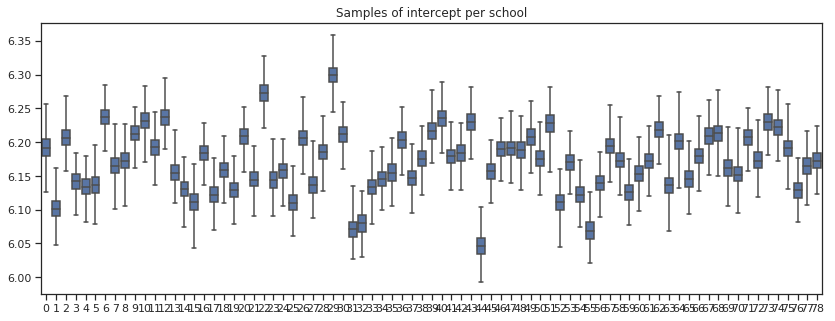

In [47]:
import seaborn as sns
sns.set(style="ticks")

a_sample = pd.DataFrame(separate_fit['alpha'])
plt.figure(figsize=(14, 5))
sns.boxplot(data=a_sample, whis=np.inf, color="b")
plt.title("Samples of intercept per school")
plt.show()


# Varying intercept and slope model

In [48]:
varying_intercept_slope = """
data {
  int<lower=0> N;
  int<lower=0> J;
  vector[N] y;
  vector[N] x;
  int school[N];
}
parameters {
  real<lower=0> sigma;
  real<lower=0> sigma_a;
  real<lower=0> sigma_b;
  vector[J] alpha;
  vector[J] beta;
  real mu_a;
  real mu_b;
}
transformed parameters {
    vector[N] mu;  
    for (i in 1:N)
        mu[i] <- alpha[school[i]] + beta[school[i]]*x[i];
}
model {
  mu_a ~ normal(0, 1);
  mu_b ~ normal(0, 1);

  alpha ~ normal(mu_a, sigma_a);
  beta ~ normal(mu_b, sigma_b);
  y ~ normal(mu, sigma);
}

generated quantities{
    vector[N] log_lik;
    for (i in 1:N)
     log_lik[i] = normal_lpdf(y[i]| mu[i], sigma);
}

"""

In [49]:
varying_intercept_slope_data = {'N': df.shape[0],
                          'J': 79,
                          'school': star.schidkn,
                          'x': df.loc[:,'year_teaching'],
                          'y': np.log(df.math)}

varying_intercept_slope_fit = pystan.stan(model_code=varying_intercept_slope, 
                                          data=varying_intercept_slope_data, 
                                          iter=1000, chains=2)
varying_intercept_slope_sample = varying_intercept_slope_fit.extract(permuted=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fc996b18191bb3d6f59ec43aa9146fea NOW.


In [50]:
print("Rhat check : ",pystan.diagnostics.check_rhat(varying_intercept_slope_fit))
print("N_eff check : ",pystan.diagnostics.check_n_eff(varying_intercept_slope_fit))
print("Divergence check: ", pystan.diagnostics.check_div(varying_intercept_slope_fit))

Rhat check :  True
N_eff check :  True
Divergence check:  True


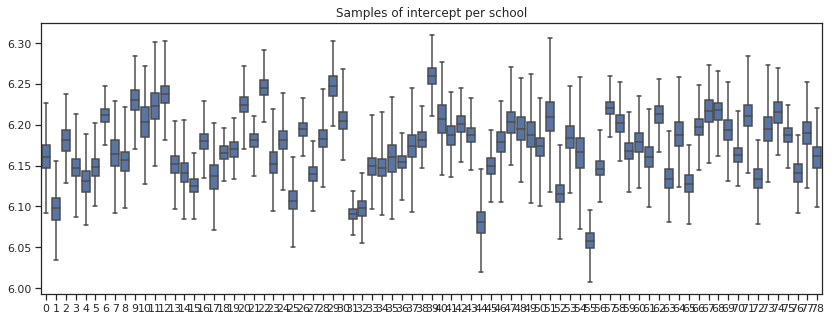

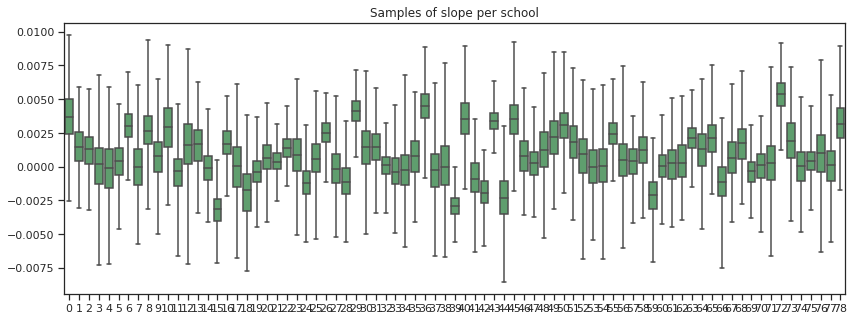

In [51]:
sns.set(style="ticks")

a_sample = pd.DataFrame(varying_intercept_slope_sample['alpha'])
plt.figure(figsize=(14, 5))
sns.boxplot(data=a_sample, whis=np.inf, color="b")
plt.title("Samples of intercept per school")
plt.show()

b_sample = pd.DataFrame(varying_intercept_slope_sample['beta'])
plt.figure(figsize=(14, 5))
sns.boxplot(data=b_sample, whis=np.inf, color = 'g')
plt.title("Samples of slope per school")
plt.show()


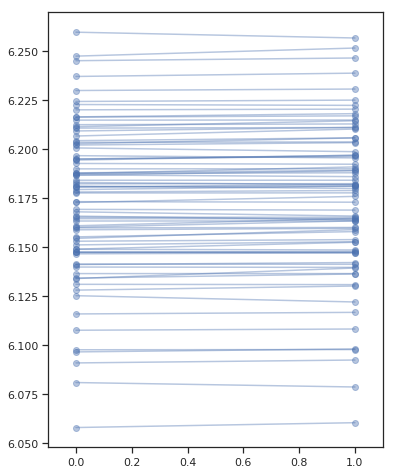

In [52]:
xvals = np.arange(2)
b = varying_intercept_slope_fit['alpha'].mean(axis=0)
m = varying_intercept_slope_fit['beta'].mean(axis=0)
plt.figure(figsize=(6,8))
for bi,mi in zip(b,m):
    plt.plot(xvals, mi*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1, 1.1);

psisloo:  5908.328201330611
p_eff:  -3671.220448457781


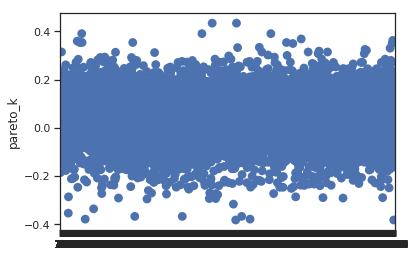

In [53]:
loglik = (varying_intercept_slope_sample["log_lik"])
psisloo = stanity.psisloo(loglik)
print("psisloo: ",psisloo.elpd)
psisloo.plot()
lppd_pooled = 0 
for i in range (Y_train.shape[0]):
    lppd_pooled = lppd_pooled + np.log(np.mean(np.exp(loglik[:,i])))

peff_pooled = np.sum(lppd_pooled) - psisloo.elpd
print("p_eff: ", peff_pooled)

In [54]:
psisloo.print_summary()

greater than 0.5    0.0
greater than 1      0.0
dtype: float64

## Hierarchical model

Since the hierarchical model is not differentiated from the separated model in predicting a group that is already present in the training data, we estimate this model's effectiveness by using one school as the predicting data and the other schools as the data feeding to the model.

First, let's look at the code.

In [55]:
hierarchical_code = """
data {
    int<lower=1> N;
    int<lower=1> K;
    matrix[N, K] y;
}
parameters {
    real mu0;
    real<lower=0> sigma0;
    vector[K] mu;
    real<lower=0> sigma;
}
model {
    for (j in 1:K){
        mu[j] ~ normal(mu0, sigma0);
        y[:,j] ~ normal(mu[j], sigma);
     }
}
generated quantities {
    real mupred;
    mupred <- normal_rng(mu0, sigma0);
}
"""

In [56]:
data = []
for s in i_schools:
    np.random.shuffle(s)
    s = s[:min_len]
    data.append(Y.iloc[s])

In [57]:
data = np.array(data)

In [58]:
mean_error = []
sigma_error = []

In [59]:
for i_pred in range(79):
    mask = np.ones(79, dtype=bool)
    mask[i_pred] = False
    y_train = data[mask]
    y_test = data[i_pred]
    data_hierarchical = {
        'N': y_train.shape[0],
        'K': y_train.shape[1],
        'y': y_train
    }
    fit_hierarchical = pystan.stan(model_code = hierarchical_code, data = data_hierarchical, iter=2000, chains=2)
    mu_pred = np.mean(fit_hierarchical['mupred'])
    sigma_pred = np.mean(fit_hierarchical['sigma'])
    mu_ytest = np.mean(y_test)
    sigma_ytest = np.std(y_test)
    mean_error.append(mu_ytest - mu_pred)
    sigma_error.append(sigma_ytest - sigma_pred)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb06

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb06

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb06

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb06

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb06

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb063ad4e6e043a948b6541ceedcd53e NOW.


In [61]:
MAE = np.mean(np.abs(mean_error))

In [62]:
MAE

0.03534605551504358